In [250]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.latex_utils as tex
import pandas as pd
from scipy.stats import shapiro, mannwhitneyu
import seaborn as sns
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util


In [251]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [252]:
measurements_used = 270
time_series_used = 10
energy_per_time = 1000
generate_graphs = False

get_timeseries = True
get_measurements = False

In [253]:
# exp_name = "compiler"
exp_name = "measuring_instrument"

In [254]:
used_dut_name = [
    'workstationone'
    # 'workstationtwo'
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    # linux
]

used_test_case_names = [
    # 'fannkuch-redux.exe',
    'mandelbrot.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug#, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg, lhm, clamp, plug#, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [255]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_mi_names = [
        ipg, clamp, plug, scaphandre #, lhm, scaphandre, # plug, rapl
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]


used_mi_names.sort()
used_compilers.sort()

In [256]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [257]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev
4,5,workstationtwo,win32nt,prod
5,6,mhk,win32nt,dev
6,7,workstationtwo,win32nt,dev


In [258]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [259]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [260]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [261]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [262]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,4,rapl,100
2,5,clamp,500
3,7,plug,100
4,8,plug,200
5,9,lhm,100
6,11,clamp,100
7,12,scaphandre,100


In [263]:
used_mi_query_list = []

if ipg in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate})")

if lhm in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

if rapl in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{rapl}' and {SAMPLE_RATE} == {rapl_sample_rate})")


if plug in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{plug}' and {SAMPLE_RATE} == {plug_sample_rate})")

if clamp in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{clamp}' and {SAMPLE_RATE} == {clamp_sample_rate})")
    
if scaphandre in used_mi_names:
    used_mi_query_list.append(f"({NAME} == '{scaphandre}' and {SAMPLE_RATE} == {scaphandre_sample_rate})")

used_mi = mi.query(" or ".join(used_mi_query_list))

In [264]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [265]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"
4,5,0,100,0,"[0, 1]"


In [266]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

In [267]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test
2,1,same-one-api-compiler-different-measuring-inst...
3,1,same-one-api-compiler-different-measuring-inst...
4,2,same-one-api-compiler-different-measuring-inst...
5,0,testing-phase


In [268]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [269]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [270]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
4,8,plug,200
6,11,clamp,100
7,12,scaphandre,100


In [271]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [272]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [273]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

begin - mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt.100.22
done
begin - mandelbrot.exe.plug.workstationone.all.intel-one-api.win32nt.200.22
done
begin - mandelbrot.exe.clamp.workstationone.all.intel-one-api.win32nt.100.22
done


In [274]:
time_series

{'mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt': [     ElapsedTime  CpuEnergyInJoules  ProcessorPowerInWatt  \
  0          116.0             3007.0               25909.0   
  1          225.0             7597.0               41986.0   
  2          335.0            12155.0               41655.0   
  3          444.0            16727.0               41812.0   
  4          553.0            21344.0               42227.0   
  ..           ...                ...                   ...   
  125      13792.0           538931.0               18000.0   
  126      13901.0           540717.0               16334.0   
  127      14010.0           542236.0               13888.0   
  128      14120.0           543742.0               13781.0   
  129      14211.0           545047.0               14318.0   
  
                                      AdditionalMetadata  
  0    {"PsysPl1InWatt": 0, "PsysPl2InWatt": 0, "GpuU...  
  1    {"PsysPl1InWatt": 0, "PsysPl2InWatt": 0, "GpuU...  
 

In [275]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
    )

In [276]:
if get_measurements:
    for key, value in dram_energy_results.items():
        dram_energy_results[key] = value[:measurements_used]
        
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:measurements_used]

    for key, value in gpu_energy_results.items():
        gpu_energy_results[key] = value[:measurements_used]

    for key, value in duration_results.items():
        duration_results[key] = value[:measurements_used]
        
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:measurements_used]

    for key, value in gpu_dynamic_energy_consumption.items():
        gpu_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in dram_dynamic_energy_consumption.items():
        dram_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in idle_cpu_consumption_results.items():
        idle_cpu_consumption_results[key] = value[:measurements_used]
        
    for key, value in temperature_end.items():
        temperature_end[key] = value[:measurements_used]

    for key, value in temperature_begin.items():
        temperature_begin[key] = value[:measurements_used]

In [277]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))

In [278]:

for p in cpu_dynamic_energy_consumption:
    x_values = range(len(cpu_dynamic_energy_consumption[p]))

    # plot the graph
    plot.plot(x_values, cpu_dynamic_energy_consumption[p])

    # add a title and labels
    plot.title(p)
    plot.xlabel("X-axis Label")
    plot.ylabel("Y-axis Label")

    # display the graph
    plot.show()

In [279]:
if get_measurements:
    config_cores == "[]"
    for key, value in dram_energy_results.items():
        dram_energy_results[key] = value[:measurements_used]
        
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:measurements_used]

    for key, value in gpu_energy_results.items():
        gpu_energy_results[key] = value[:measurements_used]

    for key, value in duration_results.items():
        duration_results[key] = value[:measurements_used]
        
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:measurements_used]

    for key, value in gpu_dynamic_energy_consumption.items():
        gpu_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in dram_dynamic_energy_consumption.items():
        dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [280]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

In [281]:
cpu_dynamic_df

""


In [282]:
def Mann(dataFrame):
    results = {}
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(dataFrame):
            stat, p = mannwhitneyu(dataFrame[col1], dataFrame[col2])
            alpha = 0.05
            results[col1][col2] = p
            # interpret the result
            if p > alpha:
                print(f"{col1} and {col2} have similar medians")
            else:
                print(f"{col1} and {col2} have significantly different medians")
    return results

def Kendall(truthFrame,dataFrame):
    results = {}
    # print(f"Kendall's correlation coefficients for {dataFrame.columns[0].split('.')[0]}:")
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(truthFrame):
            # only compare unique pairs of columns
            corr = dataFrame[col1].corr(dataFrame[col2], method='kendall')
            # print(f"{col1} and {col2}: {corr:.3f}")
            results[col1][col2] = corr
    # print()
    return results

def Sharpiro(dataFrame):
    results = {}
    for col in dataFrame.columns:
        stat, p = shapiro(cpu_dynamic_df[col])
        alpha = 0.05
        results[col] = p
        # interpret the result
        if p > alpha:
            print(f'{col} is normally distributed')
        else:
            print(f'{col} is not normally distributed')

In [283]:
def separate_names(name1, name2):
    parts1 = name1.split('.')
    parts2 = name2.split('.')
    common_parts = []
    different_parts = []

    for w in parts1:
        if(w in parts2):
            common_parts.append(w)
        else:
            different_parts.append(w)

    for w in parts2:
        if(w in parts1):
            common_parts.append(w)
        else:
            different_parts.append(w)

    return set(common_parts), set(different_parts)

def precise_seperator(target, names):
    common_parts = []
    different_parts = []
    for n in names:
        parts1 = target.split('.')
        parts2 = n.split('.')

        for w in parts1:
            if(w in parts2):
                common_parts.append(w)
            else:
                different_parts.append(w)
    return set(common_parts), set(different_parts)


def generate_latex_heatmap(data, spacing=0.6,labelSpacing=0.2,colAxisOffset=0,rowAxisOffset=0):
    row_labels = list(data.keys())
    col_labels = list(data[row_labels[0]].keys())

    # Calculate label spacing based on the length of the longest label in each axis
    row_spacing = max([len(str(precise_seperator(label,row_labels)[1])) for label in row_labels]) * labelSpacing
    col_spacing = max([len(str(precise_seperator(label,col_labels)[1])) for label in col_labels]) * labelSpacing

    header = r"""\documentclass[tikz]{standalone}
\begin{document}
\begin{figure}
\begin{tikzpicture}[scale=""" + str(spacing) + ", rowlabel/.style={minimum size=6mm, rotate=30}, collabel/.style={minimum size=6mm, rotate=60}]"

    footer = r"""\end{tikzpicture}
    """+f"\caption(This table represents the: {precise_seperator(row_labels[0],row_labels)[0]} experiments)"+r"""
    \end{figure}

\end{document}"""

    heatmap_body = ""
    for i, row_key in enumerate(row_labels):
        for j, col_key in enumerate(col_labels):
            value = data[row_key][col_key]
            color_intensity = int(value * 100)  # Adjust the intensity of the color based on the value
            heatmap_body += r"\node[fill=yellow!{}!purple, minimum size=6mm, text=white] at ({}, -{}) {{{}}};".format(color_intensity, j+1+col_spacing, i+1+row_spacing, round(value, 2))

    col_header = "\n".join([r"\node[collabel] at ({}, 0) {{{}}};".format(j+1+col_spacing, str(precise_seperator(col_label,col_labels)[1])) for j, col_label in enumerate(col_labels)])
    row_header = "\n".join([r"\node[rowlabel] at (0, -{}) {{{}}};".format(i+1+row_spacing, str(precise_seperator(row_label,row_labels)[1])) for i, row_label in enumerate(row_labels)])

    return header + col_header + row_header + heatmap_body + footer


In [284]:
if get_measurements:
    fannkuch_df = cpu_dynamic_df.filter(regex='fannkuch-redux')
    mandelbrot_df = cpu_dynamic_df.filter(regex='mandelbrot')
    truthFann = fannkuch_df.filter(regex='clamp')
    truthMand = mandelbrot_df.filter(regex='clamp')
    DiffrenceFannkuch = Mann(fannkuch_df)
    DiffrenceMandelbrot = Mann(mandelbrot_df)
    CorrelationFannkuch = Kendall(truthFann,fannkuch_df)
    CorrelationMandelbrot = Kendall(truthMand, mandelbrot_df)
    latex_heatmap = generate_latex_heatmap(DiffrenceFannkuch, spacing=0.6, labelSpacing = 0.1, colAxisOffset=0.5)
    print(latex_heatmap)

In [285]:
keys = []
key_index = 0
for key in time_series:
    keys.append(key)
print(keys[key_index])
first = time_series[keys[key_index]][5]
print(first)

mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt
     ElapsedTime  CpuEnergyInJoules  ProcessorPowerInWatt  \
0          116.0             2910.0               25035.0   
1          229.0             7625.0               41828.0   
2          335.0            12150.0               42691.0   
3          445.0            16874.0               43020.0   
4          554.0            21572.0               42960.0   
..           ...                ...                   ...   
126      13933.0           540940.0               18237.0   
127      14042.0           542526.0               14519.0   
128      14152.0           544050.0               13941.0   
129      14261.0           545555.0               13759.0   
130      14312.0           546312.0               14827.0   

                                    AdditionalMetadata  
0    {"PsysPl1InWatt": 0, "PsysPl2InWatt": 0, "GpuU...  
1    {"PsysPl1InWatt": 0, "PsysPl2InWatt": 0, "GpuU...  
2    {"PsysPl1InWatt": 0, "PsysPl2In

In [286]:
def GetMapping(key,keys):
    result = list(precise_seperator(key,keys)[1])[0]
    
    return PowerMapping[result]

PowerMapping = {
    'clamp':'CpuEnergyInJoules',
    'ipg':'ProcessorPowerInWatt',
    'scaphandre':'CpuEnergyInJoules',
    'scaphandre_isolated': 'CpuEnergyInJoules',
    'plug': 'CpuEnergyInJoules',
    'lhm': 'CpuEnergyInJoules'
}

In [287]:
# def AdaptIpgToCCF(ipg): #common correlation format
#     samplesPrSec = ipg[GetMapping[]]

mandelbrot.exe.clamp.workstationone.all.intel-one-api.win32nt
(143, 4)


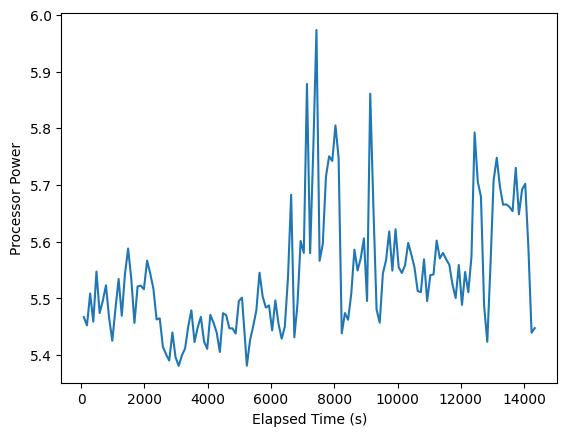

(143, 4)


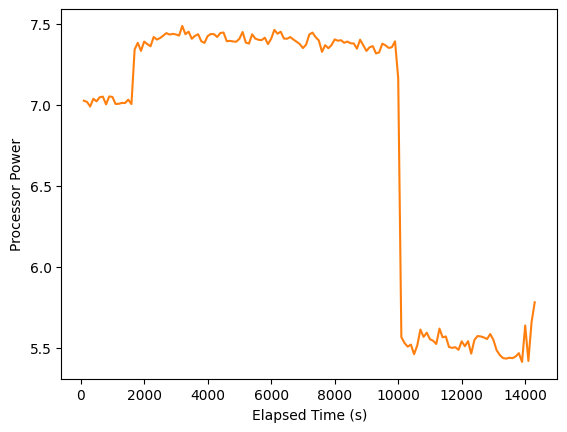

(143, 4)


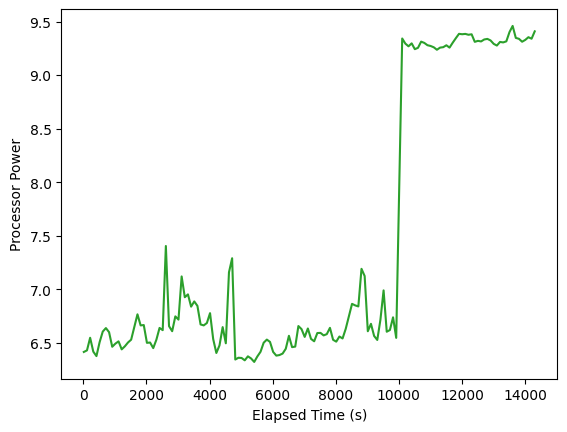

(143, 4)


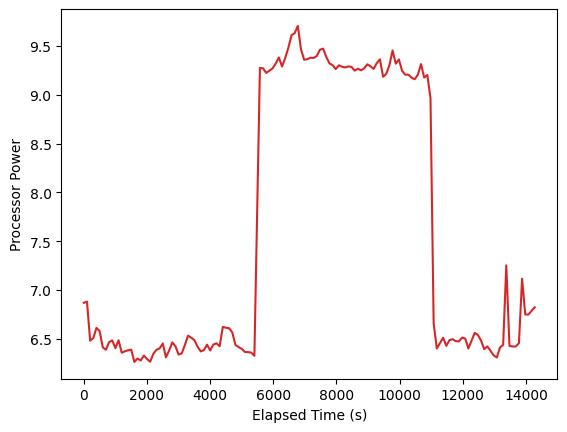

(141, 4)


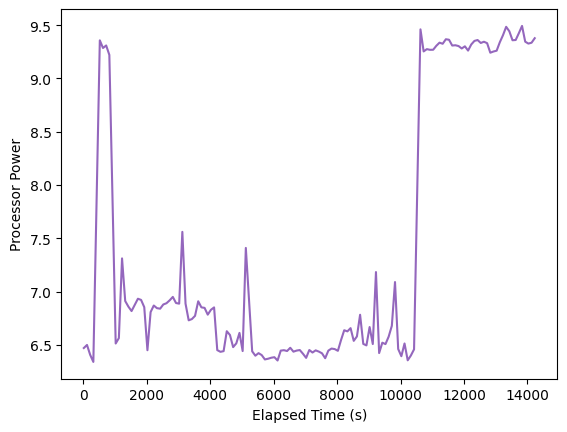

(142, 4)


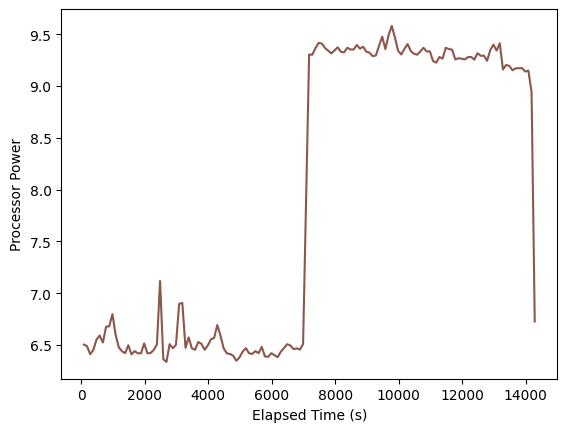

(142, 4)


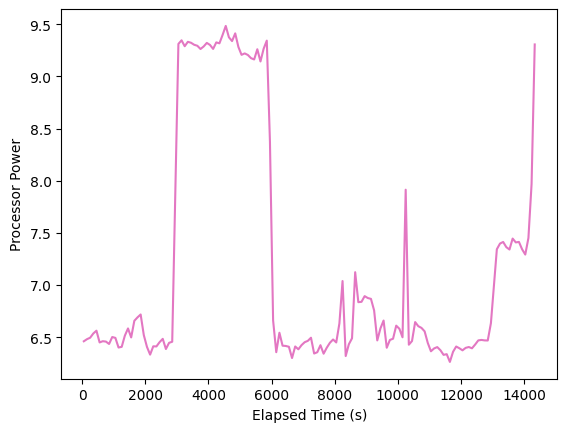

(143, 4)


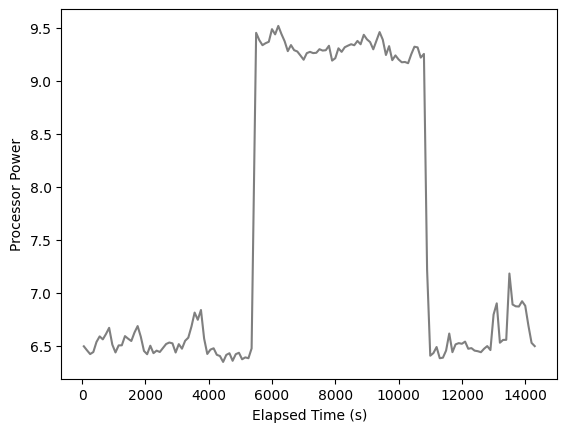

(142, 4)


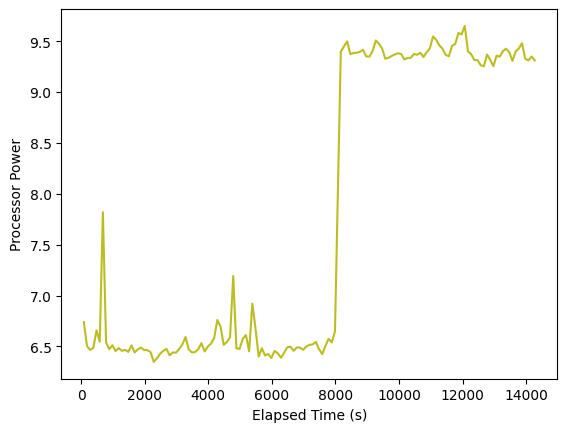

(142, 4)


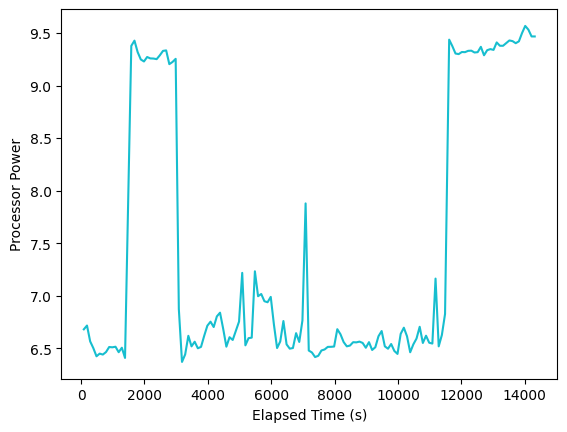

In [294]:
key_index = 2
keys = []
for key in time_series:
    keys.append(key)
    
# print(keys)
print(keys[key_index])

for i in range(len(time_series[keys[key_index]])):
    first = time_series[keys[key_index]][i] #Get the for timeSeries of the first key
    print(first.shape)
    xAxis = first['ElapsedTime'].tolist()
    yAxis = first[GetMapping(keys[key_index], keys)].tolist()

    # Create a scatter plot
    # plot.scatter(xAxis, yAxis, c=[plot.cm.tab10(i)])

    # Create a line plot
    plot.plot(xAxis, yAxis, c=plot.cm.tab10(i))

    # Add labels to the axes
    plot.xlabel('Elapsed Time (s)')
    plot.ylabel('Processor Power')

    # Show the plot
    plot.show()


In [289]:
print(keys)
print(str(list(precise_seperator(key1,keys)[1])[0]))

['mandelbrot.exe.ipg.workstationone.all.intel-one-api.win32nt', 'mandelbrot.exe.plug.workstationone.all.intel-one-api.win32nt', 'mandelbrot.exe.clamp.workstationone.all.intel-one-api.win32nt']


NameError: name 'key1' is not defined

In [ ]:
m = 0
printResult = True
plotResult = True
for key1 in keys:
    for key2 in keys:
        for i in range(len(time_series[key1])):
            for j in range(len(time_series[key2])):
                if key1 != key2:
                    partialResult = "Instrument 1: " + str(list(precise_seperator(key1,keys)[1])[0])+f"{i}\n"
                    partialResult += "Instrument 2: " + str(list(precise_seperator(key2,keys)[1])[0])+f"{j}\n"
                    partialResult += " Correlation result: \n"
                    print("key " + GetMapping(key1, keys)+"\n")
                    elapseCorr = time_series[key1][i]['ElapsedTime'].corr(time_series[key2][j]['ElapsedTime'],method="kendall")
                    jouleCorr = time_series[key1][i][GetMapping(key1, keys)].corr(time_series[key2][j][GetMapping(key2, keys)],method="kendall")
                    partialResult += f"Joules Correlation: {jouleCorr}\n"
                    partialResult += f"Elapsed Time Correlation: {elapseCorr} \n\n\n"
                    if printResult:
                        print(partialResult)

print(m)

key ProcessorPowerInWatt

Instrument 1: ipg0
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: -0.2
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg1
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: 0.3333333333333333
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg2
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: 0.2
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg3
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: 0.2
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg4
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: -0.06666666666666665
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg5
Instrument 2: scaphandre0
 Correlation result: 
Joules Correlation: 0.06666666666666665
Elapsed Time Correlation: nan 



key ProcessorPowerInWatt

Instrument 1: ipg6
